# Gaussian Mixture Model

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import peakutils
import sys
from sklearn import mixture
from sklearn import preprocessing
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import GMM
from anomaly_detection import PCA
%matplotlib inline
from IPython.display import display
from IPython.display import HTML

## Scaled vs unscaled data

In [2]:
client = mongo_client.CERNMongoClient()
df = client.query_resample("^MKI.(A|B).*B1:.*", '1T')
X, _ = df.shape
train_length = int(round(0.5 * X))
data = df.values
data_scaled = preprocessing.scale(data)
train_data = data[:train_length, :]
test_data = data[train_length:, :]
train_data_scaled = data_scaled[:train_length, :]
test_data_scaled = data_scaled[:train_length, :]

Fetching data for pattern ^MKI.(A|B).*B1:.*
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.B5L2.B1:PRESSURE
Fetching data for MKI.B5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.A5L2.B1:TEMP_TUBE_DOWN
Fetching data for MKI.B5L2.B1:PRESSURE_INT
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_DOWN
Fetching data for MKI.B5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:TEMP_TUBE_UP
Fetching data for MKI.A5L2.B1:PRESSURE_INT
Fetching data for MKI.B5L2.B1:TEMP_MAGNET_UP
Fetching data for MKI.A5L2.B1:PRESSURE
Fetching data for MKI.A5L2.B1:TEMP_MAGNET_DOWN


In [3]:
display(data_scaled.mean(axis=0))
display(data_scaled.var(axis=0))

array([ -7.72773276e-16,  -3.34373052e-17,   2.97220491e-16,
        -3.86386638e-16,  -1.70901782e-16,   1.78332294e-16,
        -6.83607129e-16,  -1.63471270e-16,   2.97220491e-17,
         7.43051227e-17,  -1.93193319e-16,   1.12943786e-15])

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

Df contains all collections for B1 with fixed frequency sampling, resampled to 1 minute. Missing values are replaced by the last real value. The data is then rescaled to center the mean of each collection around 0 and set the variance to unit. [scale function](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html#sklearn.preprocessing.scale)
The data is then split in a training and test set.

### Component Selection

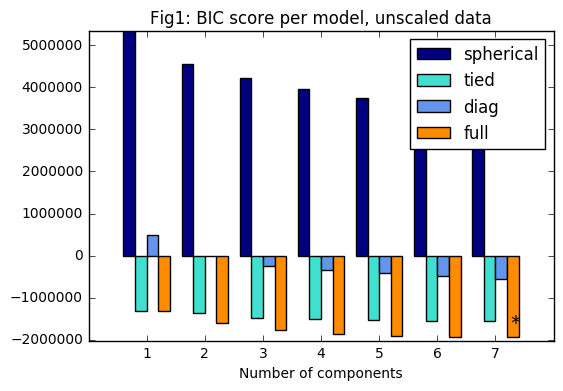

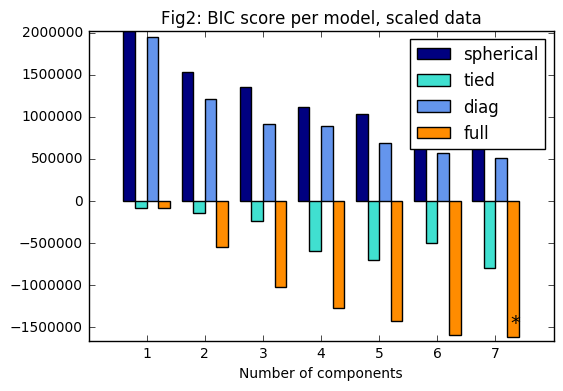

In [4]:
GMM.component_selection(train_data, 'Fig1: BIC score per model, unscaled data')
GMM.component_selection(train_data_scaled, 'Fig2: BIC score per model, scaled data')

The two function above calculate the optimal number of components and covariance matrix type to best fit the data. The first one for unscaled data, the second one for scaled data. These might take a while to compute!
The 'diag' covariance matrix type is worse with scaled data.

### GMM

In [5]:
gmm = mixture.GaussianMixture(n_components=7, covariance_type='full')
gmm_scaled = mixture.GaussianMixture(n_components=7, covariance_type='full')
gmm.fit(train_data)
gmm_scaled.fit(train_data_scaled)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=7, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [6]:
covariances = gmm.covariances_[0]
display("Unscaled covariances: %s" % covariances.diagonal())
covariances_scaled = gmm_scaled.covariances_[0]
display("Scaled covariances: %s" % covariances_scaled.diagonal())

'Unscaled covariances: [  2.85901729e+01   1.00000000e-06   1.09031149e+01   1.26199647e+01\n   1.09358343e-06   7.54164423e+00   1.35493668e+01   1.28394752e+02\n   1.00292823e-06   2.39170619e+01   1.00000000e-06   1.05671911e+01]'

'Scaled covariances: [ 0.16913468  0.00051524  0.22259197  0.18645966  0.16132237  0.17890178\n  0.45974259  0.24411319  0.42009624  0.18451901  0.02390068  0.15544566]'

The covariances\_ attribute of the gmm returns a ndarray of dimension (n_components, n_features, n_features) for a full covariance matrix. This is why the covariance matrix of the first component is taken. Then the diagonal is printed. here we can see that some variances are around 10^-6 in the unscaled version. These correspond with the pressure collections. This is improved by scaling the data.

### PCA
PCA will reduce the dimensions of the original data to 2. This will help to create better visualisations of anomalies.

'explained variance ratio (normal pca): [ 0.86852616  0.09908463]'

'explained variance ratio (scaled pca): [ 0.5898354   0.19311808]'

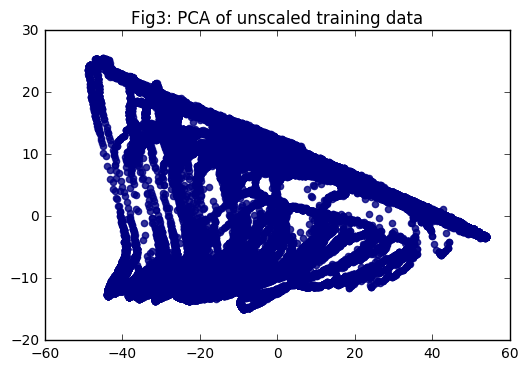

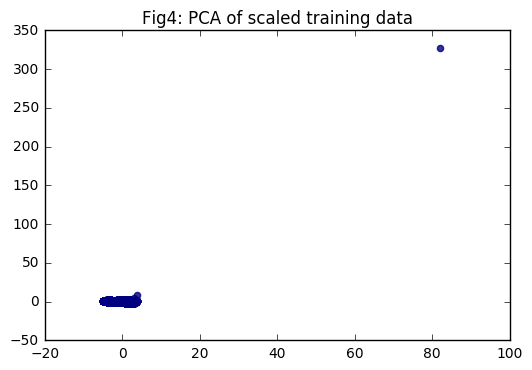

In [7]:
pca = PCA.create_pca(n_components=2)
pca_scaled = PCA.create_pca(n_components=2)
data_pca = PCA.transform_data(train_data, pca)
data_scaled_pca = PCA.transform_data(train_data_scaled, pca_scaled)
display('explained variance ratio (normal pca): %s' % str(pca.explained_variance_ratio_))
display('explained variance ratio (scaled pca): %s' % str(pca_scaled.explained_variance_ratio_))
PCA.plot_pca(data_pca, 'Fig3: PCA of unscaled training data')
PCA.plot_pca(data_scaled_pca, 'Fig4: PCA of scaled training data')

In [8]:
data_scaled_pca_df = pd.DataFrame(data_scaled_pca)
display(data_scaled_pca_df[data_scaled_pca_df[0]>60])

0           1
35397  81.934417  326.964132

Single point outlier in the PCA plot of the scaled training data. What is this point?

In [9]:
display("Point in training set: %s" % train_data[35397, :])
display("Point in scaled training set: %s" % train_data_scaled[35397, :])

'Point in training set: [  4.29000000e+01   1.82778250e-07   3.14000000e+01   3.29000000e+01\n   6.91194634e-05   3.32000000e+01   4.65000000e+01   5.04000000e+01\n   2.39667257e-04   4.07000000e+01   2.67700000e-09   3.66000000e+01]'

'Point in scaled training set: [  9.95910934e-01   3.31216695e+02  -3.99774423e-02  -1.79818440e-01\n  -9.31439223e-01   1.10055966e+00   4.42667186e-01  -1.55416899e-01\n   2.36778869e-01   9.96826270e-01   1.02329871e+02   1.07070192e+00]'

'Check whether point certainly matches point above:'

series               MKI.B5L2.B1:PRESSURE  MKI.A5L2.B1:PRESSURE
timestamps                                                     
2016-07-25 11:57:00          1.827783e-07          2.677000e-09

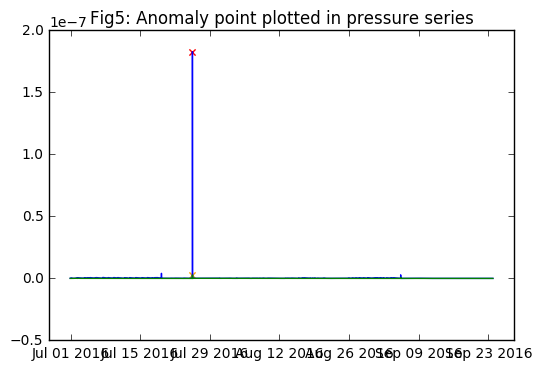

In [10]:
plt.figure()
press_data = df.filter(regex='^MKI.*.B1:PRESSURE$')
point = press_data.iloc[[35397]]
display("Check whether point certainly matches point above:")
display(point)
timestamps = df.index
for series in press_data:
    label = str(series).split(':')[0]
    plt.plot(timestamps, press_data.loc[:, series], label=label)
plt.scatter(point.index, point["MKI.B5L2.B1:PRESSURE"], marker='x', color='red')
plt.scatter(point.index, point["MKI.A5L2.B1:PRESSURE"], marker='x', color='orange')
plt.title("Fig5: Anomaly point plotted in pressure series")

Problem is the unfiltered data, filters need to be setup before running GMM/PCA.
Further experiments: removed single outlier point.

### Filtered data

In [11]:
display(df.shape)
df = df[(df["MKI.B5L2.B1:PRESSURE"] < 0.5*10**-7) & (df["MKI.A5L2.B1:PRESSURE"] < 0.5*10**-7)]
display(df.shape)
data = df.values
data_scaled = preprocessing.scale(data)
train_data = data[:train_length, :]
test_data = data[train_length:, :]
train_data_scaled = data_scaled[:train_length, :]
test_data_scaled = data_scaled[:train_length, :]

(122400, 12)

(122399, 12)

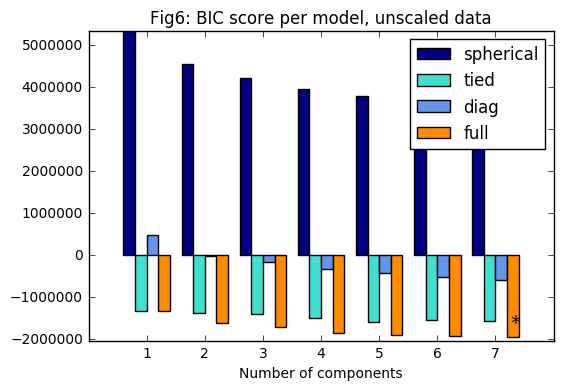

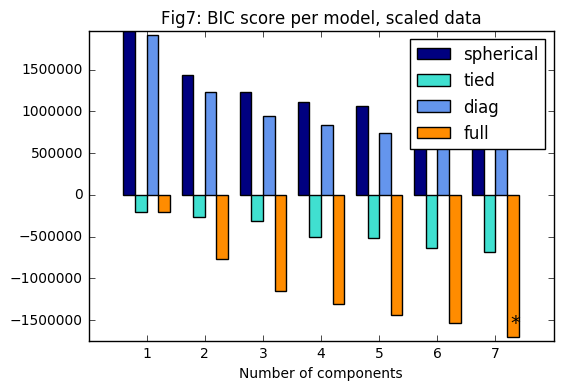

In [12]:
GMM.component_selection(train_data, 'Fig6: BIC score per model, unscaled data')
GMM.component_selection(train_data_scaled, 'Fig7: BIC score per model, scaled data')

No differences in GMM components.

'explained variance ratio (normal pca): [ 0.86853383  0.09907968]'

'explained variance ratio (scaled pca): [ 0.68993785  0.12418947]'

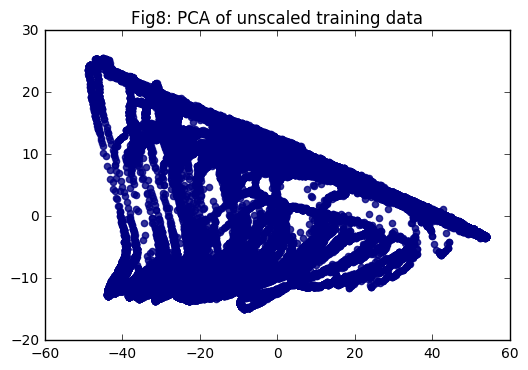

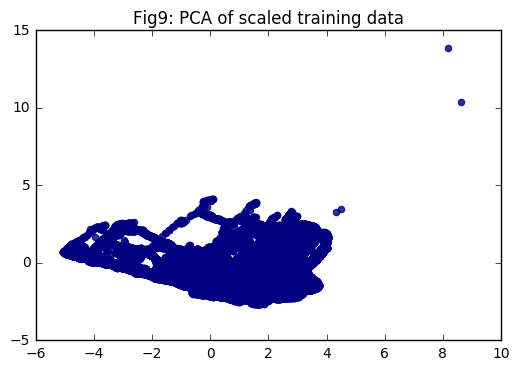

In [13]:
pca = PCA.create_pca(n_components=2)
pca_scaled = PCA.create_pca(n_components=2)
data_pca = PCA.transform_data(train_data, pca)
data_scaled_pca = PCA.transform_data(train_data_scaled, pca_scaled)
display('explained variance ratio (normal pca): %s' % str(pca.explained_variance_ratio_))
display('explained variance ratio (scaled pca): %s' % str(pca_scaled.explained_variance_ratio_))
PCA.plot_pca(data_pca, 'Fig8: PCA of unscaled training data')
PCA.plot_pca(data_scaled_pca, 'Fig9: PCA of scaled training data')

This already looks a lot better. The 4 outliers here could be removed as well, but then we are doing anomaly detection by using PCA, while the goal of PCA was only to make figures more clear. The variance ratio also improved. It is most likely going to be very close to the unscaled data once these last outliers are removed as well.

Using scaling seems a good idea to detect problems like this, even if it does not improve the GMM.

In [14]:
display('unscaled: principal axes in feature space, ordered by explained variance:')
display(pca.components_)

display('scaled: principal axes in feature space, ordered by explained variance:')
display(pca_scaled.components_)

'unscaled: principal axes in feature space, ordered by explained variance:'

array([[ -2.24618764e-01,  -4.00524058e-12,  -2.11628679e-01,
         -2.50754034e-01,  -4.48468379e-06,  -1.09492531e-01,
         -3.80367081e-01,  -7.90285646e-01,   1.08868535e-06,
         -2.09293627e-01,  -4.86555295e-13,  -1.29842871e-01],
       [  1.27917677e-01,  -5.19313065e-12,  -1.27465740e-01,
         -1.72232503e-01,   1.75217222e-06,   6.10577519e-02,
          8.62141156e-01,  -4.14154666e-01,  -4.26873326e-07,
          1.17690190e-01,  -1.05822395e-12,   7.30412769e-02]])

'scaled: principal axes in feature space, ordered by explained variance:'

array([[ 0.31673106,  0.31375835,  0.31439196,  0.32010782,  0.24900251,
         0.29566825,  0.2642932 ,  0.32946356, -0.11896814,  0.31373931,
         0.26234373,  0.30115894],
       [-0.20540209,  0.52478969,  0.01335757,  0.0602319 ,  0.1845711 ,
        -0.20472184, -0.46164972, -0.03189317, -0.04590616, -0.20813926,
         0.55019215, -0.20085708]])

From the documentation: 
Principal axes in feature space, representing the directions of maximum variance in the data. The components are sorted by explained\_variance\_.
Again, we see that all features have more or less the same importance after scaling.

## Anomaly detection

In [15]:
clf = mixture.GaussianMixture(n_components=7, covariance_type='full')
clf.fit(train_data_scaled)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=7, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [16]:
test_log_probs = clf.score_samples(test_data_scaled)
display("Log probs mean: %s" % test_log_probs.mean())
display("Log probs min: %s" % test_log_probs.min())
display("Log probs max: %s" % test_log_probs.max())
pct = np.percentile(test_log_probs, 5)
display("5 percentile: %s" % pct)
idx = np.where(test_log_probs < pct)
display("Anomaly log probs: %s" % test_log_probs[idx])
display("Number of anomalies: %s" % idx[0].shape) # the idx is a tuple with an array as first element and nothing as second element

'Log probs mean: 13.220646759'

'Log probs min: -4088.4162652'

'Log probs max: 26.8045648117'

'5 percentile: 4.72963344971'

'Anomaly log probs: [   2.9417952     2.98447961    3.00025552 ...,    3.95783751 -154.79834359\n  -49.54330814]'

'Number of anomalies: 3060'

Repeated experiment of previous notebook, now with data sampled to 1 minute, scaled data and extreme outlier removed. 

### Anomalies in PCA

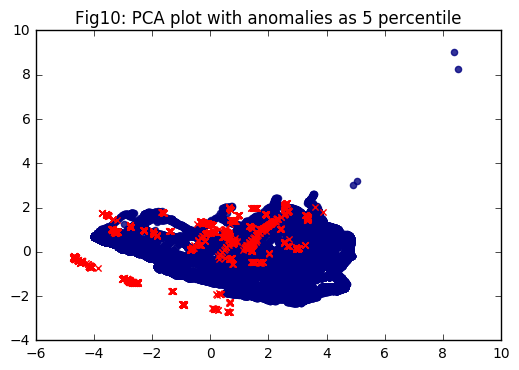

In [17]:
pca = PCA.create_pca(2)
all_data_pca = PCA.transform_data(data_scaled, pca) 
plt.figure()
# Plot the training data in blue dots
plt.scatter(all_data_pca[:train_length, 0], all_data_pca[:train_length, 1], color='navy', alpha=.8)
# idx are indexes within test set: add length of training set to get indexes in total data set
idx2 = (idx[0]+train_length, )
anomalies = all_data_pca[idx2]
plt.scatter(anomalies[:, 0], anomalies[:, 1], marker='x', color='red')
plt.title('Fig10: PCA plot with anomalies as 5 percentile')

Remarks:
- Points seem to be a bit grouped
- Some points outside of training data pca
- Extreme outlier points are not detected

### Anomalies in timeseries

In [38]:
def plot_anomalies_timeseries(series_name, fig_nb):
    plt.figure()
    regex = '^MKI.*.B1:%s$' % series_name
    timeseries = df.filter(regex=regex)
    timestamps = timeseries.index
    anomalies_timeseries = df.iloc[idx2[0].tolist()]
    for series in timeseries:
        label = str(series).split(':')[0]
        plt.plot(timestamps, timeseries.loc[:, series], label=label)
        plt.scatter(anomalies_timeseries.index, anomalies_timeseries.loc[:, series], marker='x', color='red')
    plt.title("Fig%d: Anomalies plotted in %s series" % (fig_nb, series_name))

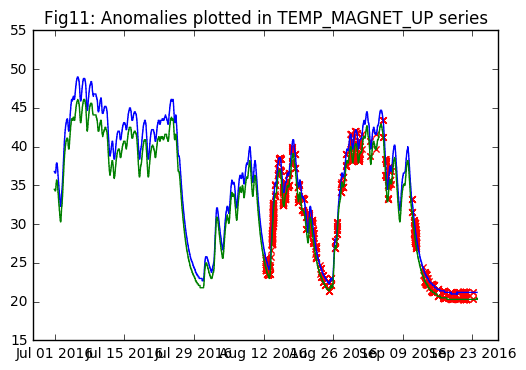

In [39]:
plot_anomalies_timeseries("TEMP_MAGNET_UP", 11)

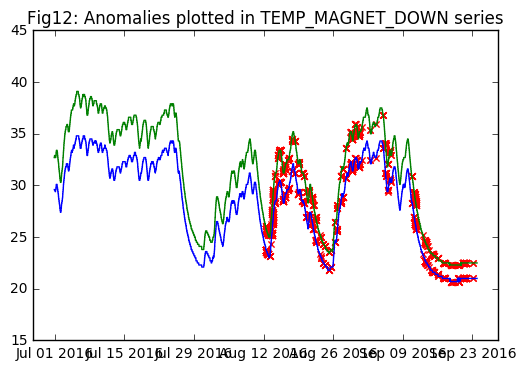

In [40]:
plot_anomalies_timeseries("TEMP_MAGNET_DOWN", 12)

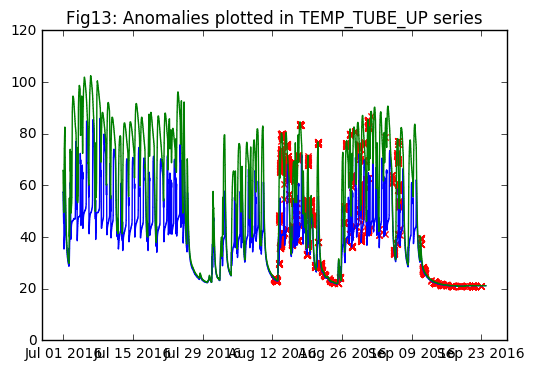

In [41]:
plot_anomalies_timeseries("TEMP_TUBE_UP", 13)

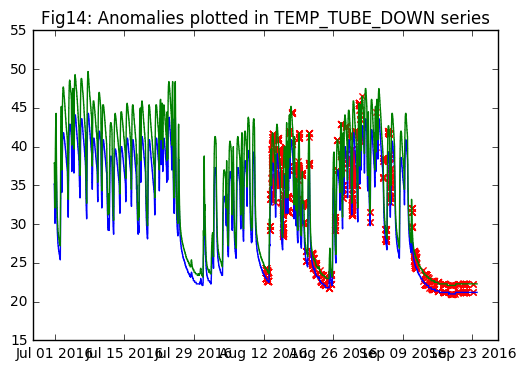

In [42]:
plot_anomalies_timeseries("TEMP_TUBE_DOWN", 14)

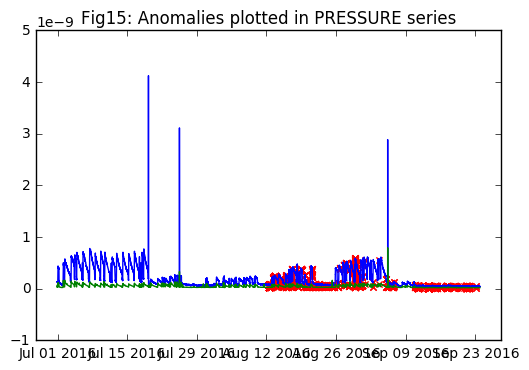

In [44]:
plot_anomalies_timeseries("PRESSURE", 15)

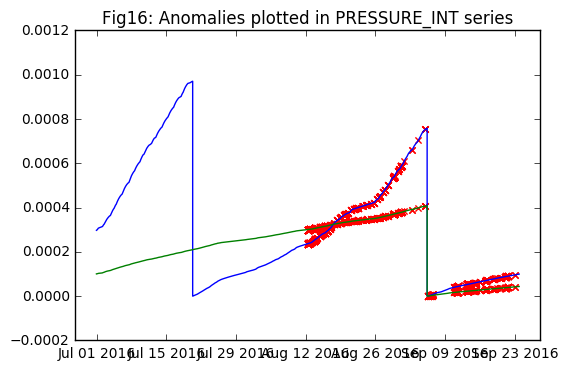

In [45]:
plot_anomalies_timeseries("PRESSURE_INT", 16)

Remarks:
- anomalies dont really seem anomalies
- extra filtering needed (still spikes in PRESSURE)
- filter out downtime: all detected as anomaly